In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import model_from_json
import matplotlib.pyplot as plt
import matplotlib
import brewer2mpl
import numpy as np
import pandas as pd

set3 = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
%matplotlib inline

## Loading CNN Model

In [11]:
# load json and create model
json_file = open('data/results/model.json','r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into model
model.load_weights('data/weights/model.h5')

## Data Summary

| FER2013 data | count|
|:-------------|-----:|
|Training      | 28709|
|Private Test  |  3589|
|Public Test   |  3589|

| Training set | count|
|:-------------|-----:|
|Angry         |  4431|
|Fear          |  4097|
|Happy         |  7215|
|Sad           |  4830|
|Surprise      |  3171|
|Neutral       |  4965|

## Model Accuracy

In [14]:
# import public test:
X_fname = 'data/X_publictest6_100pct.npy'
y_fname = 'data/y_publictest6_100pct.npy'
X = np.load(X_fname)
y = np.load(y_fname)
print 'Public test set'
y_labels = [np.argmax(lst) for lst in y]
counts = np.bincount(y_labels)
labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print zip(labels, counts)
# evaluate model on public test set
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = model.evaluate(X, y, verbose=0)
print "model %s: %.2f%%" % (model.metrics_names[1], score[1]*100)

Public test set
[('angry', 523), ('fear', 496), ('happy', 895), ('sad', 653), ('surprise', 415), ('neutral', 607)]
model acc: 57.34%


In [15]:
# import private test:
X_fname = 'data/X_train_privatetest6_100pct.npy'
y_fname = 'data/y_train_privatetest6_100pct.npy'
X = np.load(X_fname)
y = np.load(y_fname)
print 'Private test set'
y_labels = [np.argmax(lst) for lst in y]
counts = np.bincount(y_labels)
labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print zip(labels, counts)
# evaluate model on private test set
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = model.evaluate(X, y, verbose=0)
print "model %s: %.2f%%" % (model.metrics_names[1], score[1]*100)

Private test set
[('angry', 546), ('fear', 528), ('happy', 879), ('sad', 594), ('surprise', 416), ('neutral', 626)]
model acc: 58.07%


## Data Vizualization

In [16]:
def overview(start, end, X):
    fig = plt.figure(figsize=(8,10))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(16,12,i+1)
        ax.imshow(input_img[0,0,:,:], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

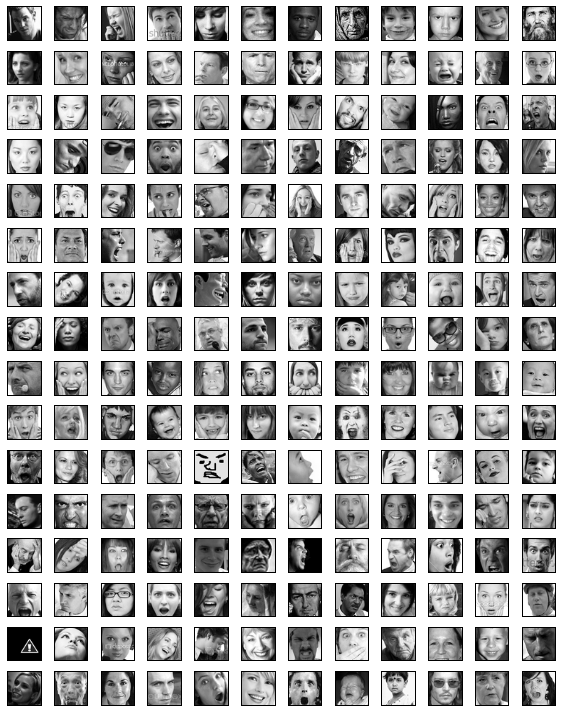

In [17]:
overview(0,191, X) # overview of face data as thumbnails (private)

In [18]:
def plot_filters(layer, x, y):
    filters = layer.W.get_value()
    fig = plt.figure(figsize=(8, 4))
    for j in range(len(filters)):
        ax = fig.add_subplot(y, x, j+1)
        ax.matshow(filters[j][0], cmap = matplotlib.cm.Blues)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()
    return plt

<module 'matplotlib.pyplot' from '//anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

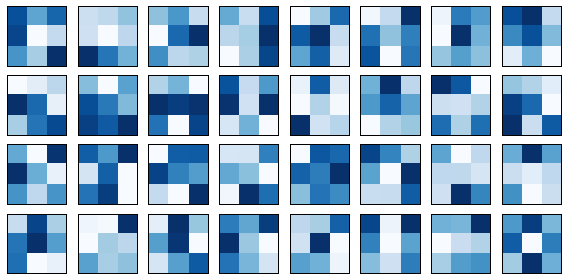

In [19]:
plot_filters(model.layers[0], 8, 4)
# plot_filters(model.layers[4], 8, 8)
# plot_filters(model.layers[10], 16, 8)

(1, 1, 48, 48)


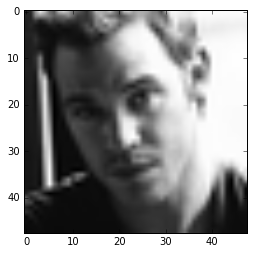

In [20]:
input_img = X[0:1,:,:,:] # subject0
print input_img.shape
plt.imshow(input_img[0,0,:,:], cmap='gray')

## Computer Vision

In [34]:
import theano
def plot_interlayer_outputs(input_img, layer_num1, layer_num2, colormaps=False):
    output_fn = theano.function([model.layers[layer_num1].input], # import theano
                                 model.layers[layer_num2].output, allow_input_downcast=True)
    im = output_fn(input_img) #filtered image
    print im.shape
    n_filters = im.shape[1]
    fig = plt.figure(figsize=(12,6))
    for i in range(n_filters):
        ax = fig.add_subplot(n_filters/16,16,i+1)
        if colormaps:
            ax.imshow(im[0,i,:,:], cmap='Blues')#seq_colors[i]
        else:
            ax.imshow(im[0,i,:,:], cmap=matplotlib.cm.gray) #matplotlib.cm.gray
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

(1, 32, 48, 48)


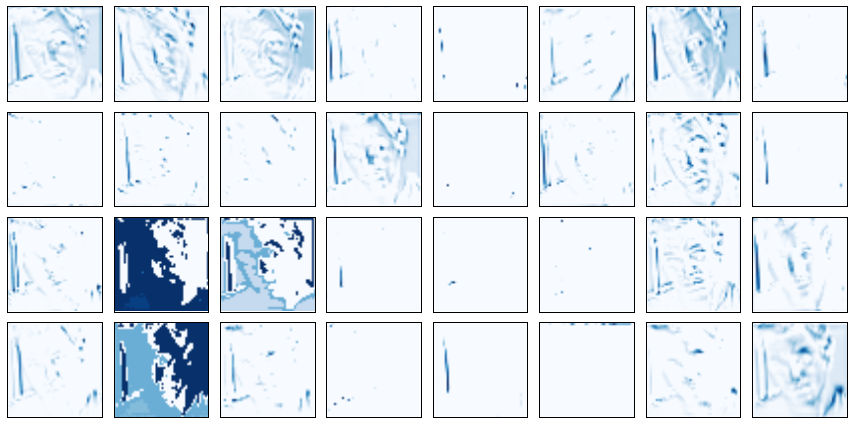

In [26]:
plot_interlayer_outputs(input_img, 0, 1, colormaps=True)
# figsize=(12,6)
# ax = fig.add_subplot(n_filters/8,8,i+1)

(1, 64, 24, 24)


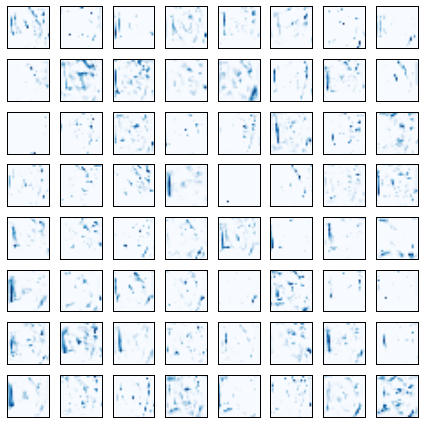

In [33]:
plot_interlayer_outputs(input_img, 0, 4, colormaps=True) 
# figsize=(6,6)
# ax = fig.add_subplot(n_filters/8,8,i+1)

(1, 128, 12, 12)


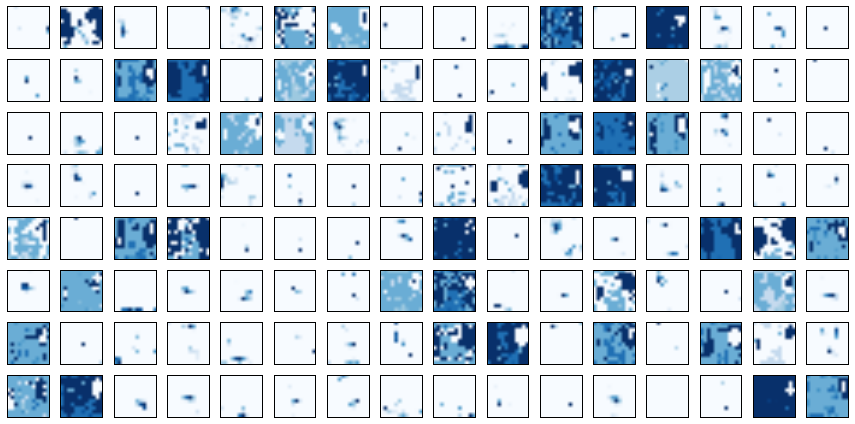

In [35]:
plot_interlayer_outputs(input_img, 0, 10, colormaps=True) 
# figsize=(12,6)
# ax = fig.add_subplot(n_filters/16,16,i+1)

## Prediction Result

In [36]:
# prediction and true labels
y_prob = model.predict(X, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y]

In [37]:
def plot_subjects(start, end, y_pred, y_true, title=False):
    fig = plt.figure(figsize=(12,12))
    emotion = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Sad', 4:'Surprise', 5:'Neutral'}
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img[0,0,:,:], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel(emotion[y_true[i]], color='#53b3cb',fontsize=12)
        else:
            plt.xlabel(emotion[y_true[i]], fontsize=12)
        if title:
            plt.title(emotion[y_pred[i]], color='blue')
        plt.tight_layout()
    plt.show()

In [38]:
def plot_probs(start,end, y_prob):
    fig = plt.figure(figsize=(12,12))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.bar(np.arange(0,6), y_prob[i], color=set3,alpha=0.5)
        ax.set_xticks(np.arange(0.5,6.5,1))
        labels = ['angry', 'fear', 'happy', 'sad', 'surprise','neutral']
        ax.set_xticklabels(labels, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

In [39]:
def plot_subjects_with_probs(start, end, y_prob):
    iter = (end - start)/6
    for i in np.arange(0,iter):
        plot_subjects(i*6,(i+1)*6-1, y_pred, y_true, title=False)
        plot_probs(i*6,(i+1)*6-1, y_prob)

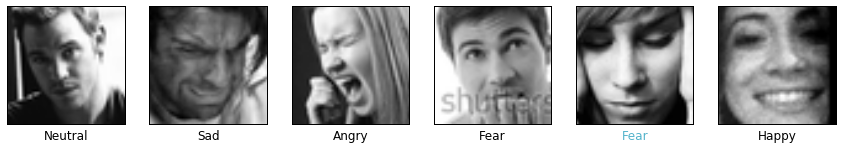

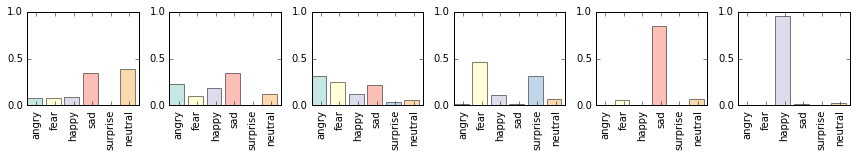

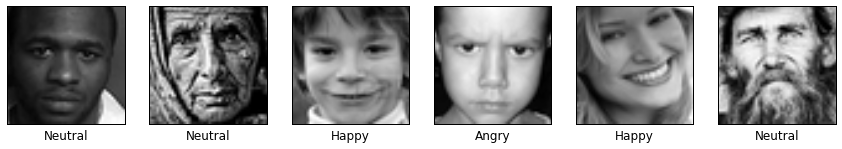

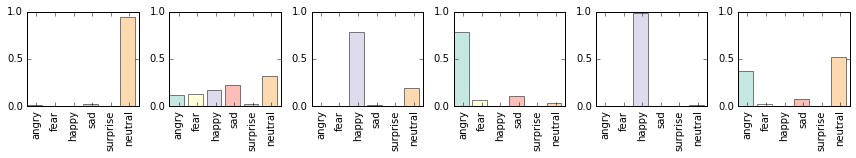

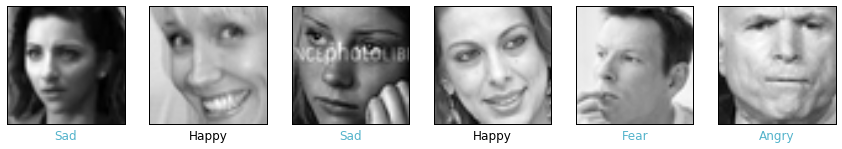

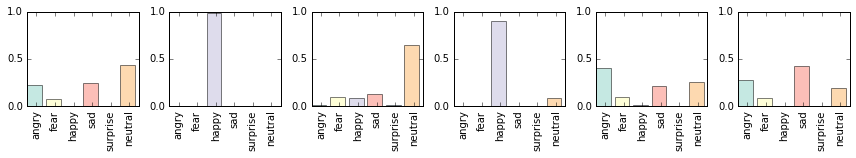

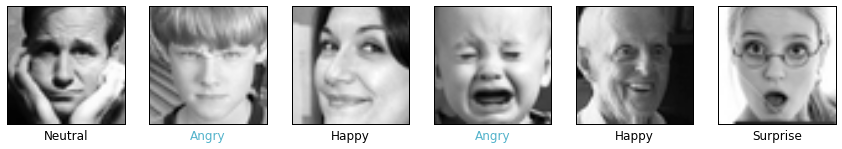

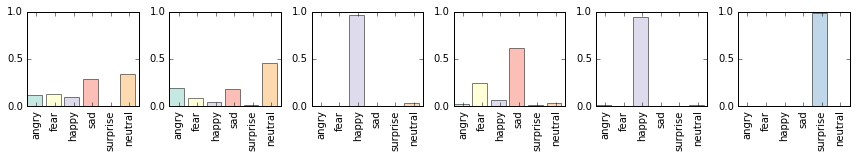

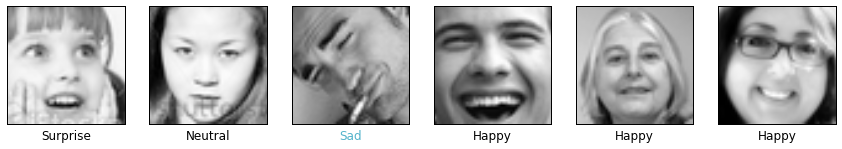

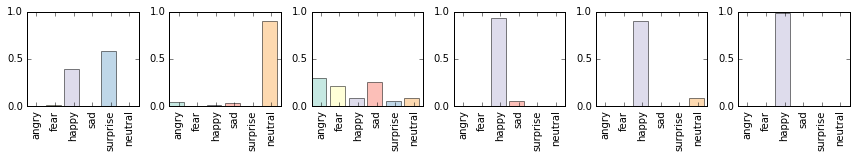

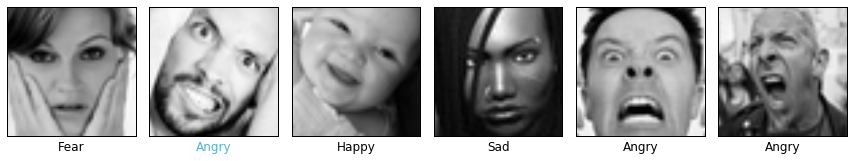

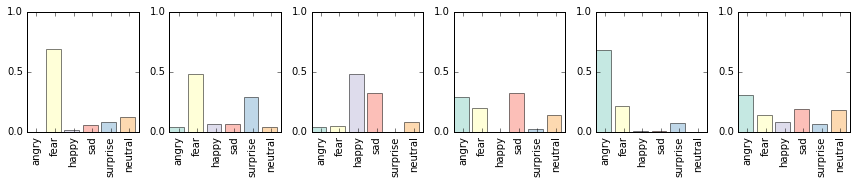

In [40]:
plot_subjects_with_probs(0, 36, y_prob)

In [54]:
y_fname1 = 'data/y_publictest6_100pct.npy'
y_fname3 = 'data/y_privatetest6_100pct.npy'
y_fname2 = 'data/y_train6.npy'
y_train = np.load(y_fname2) # train
y_public = np.load(y_fname1) # public
y_private = np.load(y_fname3) # private
y_train_labels  = [np.argmax(lst) for lst in y_train]
y_public_labels = [np.argmax(lst) for lst in y_public]
y_private_labels = [np.argmax(lst) for lst in y_private]

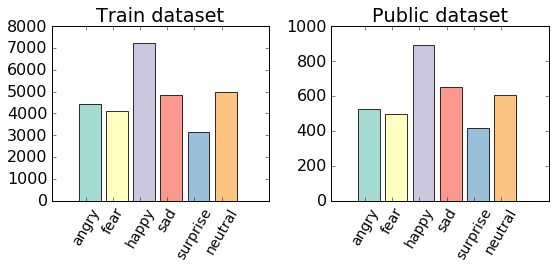

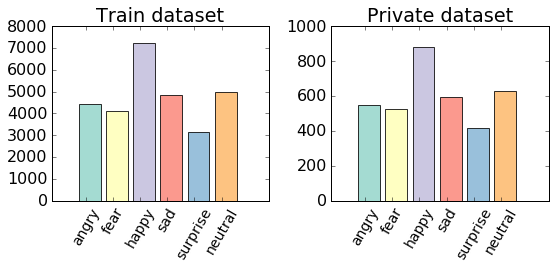

In [56]:
def plot_distribution(y1, y2, data_names, ylims =[1000,1000]): 
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.bar(np.arange(1,7), np.bincount(y1), color=set3, alpha=0.8)
    ax1.set_xticks(np.arange(1.25,7.25,1))
    ax1.set_xticklabels(labels, rotation=60, fontsize=14)
    ax1.set_xlim([0, 8])
    ax1.set_ylim([0, ylims[0]])
    ax1.set_title(data_names[0])
    ax2 = fig.add_subplot(1,2,2)
    ax2.bar(np.arange(1,7), np.bincount(y2), color=set3, alpha=0.8)
    ax2.set_xticks(np.arange(1.25,7.24,1))
    ax2.set_xticklabels(labels, rotation=60, fontsize=14)
    ax2.set_xlim([0, 8])
    ax2.set_ylim([0, ylims[1]])
    ax2.set_title(data_names[1])
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_train_labels, y_public_labels, \
                  ['Train dataset', 'Public dataset'], \
                  ylims =[8000,1000]) 
plot_distribution(y_train_labels, y_private_labels, \
                  ['Train dataset', 'Private dataset'], \
                  ylims =[8000,1000]) 

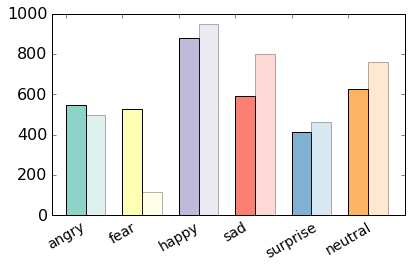

In [52]:
def plot_distribution(y_true, y_pred):
    ind = np.arange(1.5,7,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color=set3, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=set3, alpha=0.3)
    ax.set_xticks(np.arange(1.5,7,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 7.5])
    ax.set_ylim([0, 1000])
    ax.set_title('True and Predicted Label Count (Private)')
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_true, y_pred)

## Confusion Matrix

In [50]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,6):
        for j in range(0,6):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

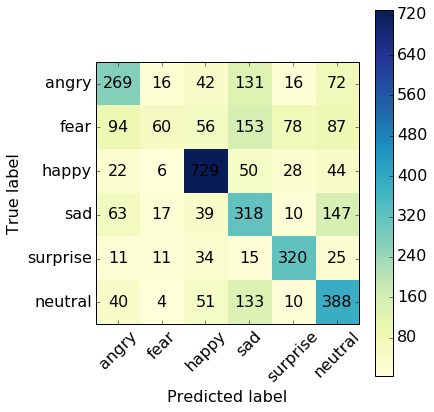

In [51]:
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)

## Classification Metrics

In [115]:
def class_precision(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    col = [cm[j,i] for j in range(0,6)]
    return float(col[i])/sum(col)

def class_recall(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    row = [cm[i,j] for j in range(0,6)]
    return float(row[i])/sum(row)

def class_accuracy(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    tp = cm[i,i]
    fn = sum([cm[i,j] for j in range(0,6) if j != i])
    fp = sum([cm[j,i] for j in range(0,6) if j != i])
    tn = sum([cm[i,j] for j in range(0,6) for i in range(0,6)]) -(tp+fp+fn)
    return float(tp + tn)/sum([tp, fn, fp, tn])

In [117]:
# private test set
for emotion in labels:
    print emotion.upper()
    print '   acc = {}'.format(class_accuracy(y_true, y_pred, emotion))
    print '  prec = {}'.format(class_precision(y_true, y_pred, emotion))
    print 'recall = {}\n'.format(class_recall(y_true, y_pred, emotion))

ANGRY
   acc = 0.858735023683
  prec = 0.539078156313
recall = 0.492673992674

FEAR
   acc = 0.854555586514
  prec = 0.526315789474
recall = 0.113636363636

HAPPY
   acc = 0.896349958206
  prec = 0.766561514196
recall = 0.829351535836

SAD
   acc = 0.788799108387
  prec = 0.3975
recall = 0.535353535354

SURPRISE
   acc = 0.933686263583
  prec = 0.692640692641
recall = 0.769230769231

NEUTRAL
   acc = 0.829200334355
  prec = 0.508519003932
recall = 0.619808306709



In [119]:
from sklearn.metrics import classification_report
print classification_report(y_true, y_pred, target_names=labels)

             precision    recall  f1-score   support

      angry       0.54      0.49      0.51       546
       fear       0.53      0.11      0.19       528
      happy       0.77      0.83      0.80       879
        sad       0.40      0.54      0.46       594
   surprise       0.69      0.77      0.73       416
    neutral       0.51      0.62      0.56       626

avg / total       0.58      0.58      0.56      3589



In [163]:
n = len(y_true)
y_fir = []
y_sec = []
y_trd = []
for i in range(n):
    if y_true[i] == np.argsort(y_prob[i])[-1]:
        y_fir.append([i, y_true[i]])
    if y_true[i] == np.argsort(y_prob[i])[-2]:
        y_sec.append([i, y_true[i]])
    if y_true[i] == np.argsort(y_prob[i])[-3]:
        y_trd.append([i, y_true[i]])
print float(len(y_fir))/n
print float(len(y_sec))/n
print float(len(y_trd))/n

0.580663137364
0.183895235442
0.111173028699


In [170]:
misclass = [float(len(y_fir))/n, float(len(y_sec))/n, float(len(y_trd))/n]

In [157]:
len(y_sec)/(len(y_true)*0.58)

0.3170607507614262

In [155]:
len(y_true)*0.58

2081.62

(array([ 110.,    0.,  161.,    0.,   67.,    0.,  142.,    0.,   35.,  145.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Patch objects>)

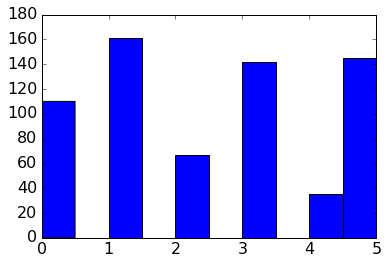

In [147]:
plt.hist([pair[1] for pair in y_sec])

In [148]:
from sklearn.metrics import hamming_loss
hamming_loss(y_true, y_pred)

0.4193368626358317

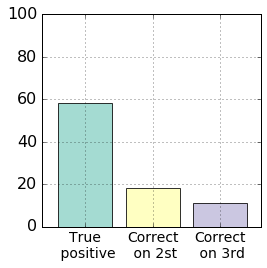

In [188]:
def plot_misclass_distribution(y, tags): 
    fig = plt.figure(figsize=(4,4))
    ax1 = fig.add_subplot(1,1,1)
    ax1.bar(np.arange(1,len(y)+1), np.array(y)*100, color=set3, alpha=0.8)
    ax1.set_xticks(np.arange(1.40,len(y)+1.40,1))
    ax1.set_xticklabels(tags, rotation=0, fontsize=14)
    ax1.set_xlim([0.75, len(y)+1])
    ax1.set_ylim([0,100])
    ax1.grid(True)
    ax1.set_title('')
    plt.tight_layout()
    plt.show()
tags = ['True\n positive','Correct\n on 2st','Correct\n on 3rd']
plot_misclass_distribution(misclass, tags)